 ## Tacotron 2 inference code
 Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

 #### Import libraries and setup matplotlib

In [1]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                    interpolation='none')
# %% [markdown]



In [2]:
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###

import matplotlib
import warnings
warnings.filterwarnings('ignore')

#matplotlib inline
import matplotlib.pylab as plt
## for compute y 
from data_utils import TextMelLoader, TextMelCollate
from torch.utils.data import DataLoader

import multiprocessing
multiprocessing.set_start_method('spawn', True)



import IPython.display as ipd
import os 
os.chdir('/research/crissp/lebbat/NVIDIA-official/tacotron2_gpu2/')
print(os.getcwd())
import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from waveglow.denoiser import Denoiser
import random
#import audio
#from audio import _denormalize_tensorflow,_db_to_amp_tensorflow,_mel_to_linear_tensorflow,_build_mel_basis,_griffin_lim_tensorflow
import tensorflow as tf
##
import stft 


#torch.manual_seed(0)



/research/crissp/lebbat/NVIDIA-official/tacotron2_gpu2


In [3]:
def split_title_line(title_text, max_words=10):
    """
    A function that splits any string based on specific character
    (returning it with the string), with maximum number of words on it
    """
    seq = title_text.split()
    return '\n'.join([' '.join(seq[i:i + max_words]) for i in range(0, len(seq), max_words)])
    # %% [markdown]


In [4]:
def plot_alignment(alignment, path, title=None, split_title=False, max_len=None):
    if max_len is not None:
        alignment = alignment[:, :max_len]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    im = ax.imshow(
        alignment,
        aspect='auto',
        origin='lower', 
        interpolation='none')
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'

    if split_title:
        title = split_title_line(title)

    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    plt.savefig(path, format='png')
    # To NOT SHOW
    plt.close()

    #%% [markdown]


In [5]:
def plot_wave(predicted_wave, path=None, title=None, split_title=False, target_wave=None, max_len=None, auto_aspect=False):
    if max_len is not None:
        target_wave = target_wave[:max_len]
        predicted_wave = predicted_wave[:max_len]
    fig, ax = plt.subplots(figsize=(20, 8))
        #fig = plt.figure(figsize=(8, 6)) # it was(10, 8)
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    center = left + width/2
    # Set common labels
    # set title 
    if title is not None:
        if split_title:
            title = split_title_line(title) 
        fig.text(center, top,title, horizontalalignment='center',verticalalignment='center', fontsize=16)
        
    #plt.figure()
    plt.plot(predicted_wave)
#     if target_wave is not None:
#         ax1 = fig.add_subplot(311)
#         ax2 = fig.add_subplot(312)

#         if auto_aspect:
#             im = ax1.imshow(np.rot90(target_wave), aspect='auto', interpolation='none')
#         else:
#             im = ax1.imshow(np.rot90(target_wave), interpolation='none')
#         ax1.set_title('Target Wave')
#         fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
#         ax2.set_title('Predicted Wave')
#     else:
#         #ax2 = fig.add_subplot(211) # it was add_subplot(211)
#          ax1 = fig.add_subplot(311)
#          ax2 = fig.add_subplot(312)
#     if auto_aspect:
#         im = ax2.imshow(np.rot90(predicted_wave), aspect='auto', interpolation='none')
#     else:
#         im = ax2.imshow(predicted_wave, aspect='auto', origin='bottom', interpolation='none')
#     fig.colorbar(mappable=im, shrink=0.2, orientation='horizontal', ax=ax2)

#     plt.tight_layout()
    if path is not None :
        plt.savefig(path, format='png')
        # To NOT SHOW
    plt.close()

In [6]:
def plot_spectrogram(pred_spectrogram, path=None, title=None, split_title=False, target_spectrogram=None, max_len=None, auto_aspect=False):
    if max_len is not None:
        target_spectrogram = target_spectrogram[:max_len]
        pred_spectrogram = pred_spectrogram[:max_len]

    if split_title:
        title = split_title_line(title)

    fig = plt.figure(figsize=(8, 6)) # it was(10, 8)
    # Set common labels
    fig.text(0.5, 0.18, title, horizontalalignment='center', fontsize=16)

    #target spectrogram subplot
    if target_spectrogram is not None:
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(312)

        if auto_aspect:
            im = ax1.imshow(np.rot90(target_spectrogram), aspect='auto', interpolation='none')
        else:
            im = ax1.imshow(np.rot90(target_spectrogram), interpolation='none')
        ax1.set_title('Target Mel-Spectrogram')
        fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
        ax2.set_title('Predicted Mel-Spectrogram')
    else:
        ax2 = fig.add_subplot(211) # it was add_subplot(211)

    if auto_aspect:
        im = ax2.imshow(np.rot90(pred_spectrogram), aspect='auto', interpolation='none')
    else:
        im = ax2.imshow(pred_spectrogram, aspect='auto', origin='bottom', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax2)

    plt.tight_layout()
    if path is not None :
        plt.savefig(path, format='png')
        # To NOT SHOW
        plt.close()




In [7]:
def plot_gate_outputs_to_numpy(gate_outputs,path=None, title=None, split_title=False):
    fig, ax = plt.subplots(figsize=(12, 3))
        #fig = plt.figure(figsize=(8, 6)) # it was(10, 8)
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    center = left + width/2
    # Set common labels
    # set title 
    if title is not None:
        if split_title:
            title = split_title_line(title) 
        fig.text(center, top,title, horizontalalignment='center',verticalalignment='center', fontsize=16)
    #ax.scatter(range(len(gate_targets)), gate_targets, alpha=0.7,
            #color='green', marker='+', s=3, label='target')
    ax.scatter(range(len(gate_outputs)), gate_outputs, alpha=1,
            color='red', marker='.', s=10, label='predicted')

    plt.xlabel("Frames ( Red predicted)")
    plt.ylabel("Gate State")
    plt.tight_layout()

    fig.canvas.draw()
    
    if path is not None :
        plt.savefig(path, format='png')
        # To NOT SHOW
        plt.close()
    #plt.show()    
    

# %% [markdown]
# #### Setup hparams


In [8]:
hparams = create_hparams()
hparams.max_decoder_steps=5000
hparams.sampling_rate = 22050
hparams.batch_size = 2
#hparams.training_files = 'FR-fr_Our/difficile_text'
data_name = hparams.training_files.strip().split('/')
data_name =data_name[-1]

# %% [markdown]
# #### Load model from checkpoint


In [11]:
checkpoint_path = "/research/crissp/lebbat/NVIDIA-official/tacotron2_gpu2/out/checkpoint_6000"
#checkpoint_path = "/research/crissp/lebbat/NVIDIA-official/tacotron2/outdir/checkpoint_16000"
#checkpoint_path = "tacotron2_statedict.pt"
checkpoint_name = checkpoint_path.strip().split('/')
checkpoint_name = checkpoint_name[-1]
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#random.seed(0)
#np.random.seed(0)
train_dir = os.path.join(os.getcwd(), 'train-eval_'+ checkpoint_name + data_name)
val_dir = os.path.join(os.getcwd(), 'val-eval_'+ checkpoint_name + data_name)
test_dir = os.path.join(os.getcwd(), 'test-eval_'+ checkpoint_name + data_name)
difficile_dir = os.path.join(os.getcwd(), 'difficile-eval_'+ checkpoint_name + data_name)

plot_train_dir = os.path.join(train_dir, 'plots')
plot_val_dir = os.path.join(val_dir, 'plots')
plot_test_dir = os.path.join(test_dir, 'plots')
plot_difficile_dir = os.path.join(difficile_dir, 'plots')

wav_dir_sTrain = os.path.join(train_dir, 'wavs')
wav_dir_sVal = os.path.join(val_dir, 'wavs')
wav_dir_sTest = os.path.join(test_dir, 'wavs')
wav_dir_difficile = os.path.join(difficile_dir, 'wavs')


# os.makedirs(plot_train_dir, exist_ok=True)
# os.makedirs(plot_val_dir, exist_ok=True)
# os.makedirs(plot_test_dir, exist_ok=True)
# os.makedirs(plot_difficile_dir, exist_ok=True)

# os.makedirs(wav_dir_sTrain, exist_ok=True)
# os.makedirs(wav_dir_sVal, exist_ok=True)
# os.makedirs(wav_dir_sTest, exist_ok=True)
# os.makedirs(wav_dir_difficile, exist_ok=True)



holy cow


#### %% [markdown]
#### Load WaveGlow for mel2audio synthesis and denoiser





In [29]:
waveglow_path = 'waveglow_256channels_ljs_v2_new.pt'
#waveglow_path = 'waveglow_90000'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)


In [13]:
def prepare_dataloaders(hparams):
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    train_loader = DataLoader(trainset, num_workers=1, shuffle=False,
                            sampler=None,
                            batch_size=hparams.batch_size, pin_memory=False,
                            drop_last=False, collate_fn=collate_fn)
    return train_loader, valset, collate_fn



In [14]:
from scipy.io import wavfile
def save_wav(wav, path, sr):
	wav *= 32767 / max(0.01, np.max(np.abs(wav)))
	#proposed by @dsmiller
	wavfile.write(path, sr, wav.astype(np.int16))

# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###

In [15]:
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
train_loader, valset, collate_fn = prepare_dataloaders(hparams)
for i, batch in enumerate(train_loader):
    x, y = model.parse_batch(batch)
    y_pred = model(x)
    #print(batch)
    #print(y)
    #print(x)


KeyboardInterrupt: 

In [37]:
# #### Prepare TEXT split ###***CHANGE IN MODEL***###
def get_sentence(hparams):
    with open(hparams.training_files, encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split('|')
            #get the text part easy
            text = parts[1]
            #get the FR-fr_Our/_wav_utt/ES_LMP_NEB_02_0011_19 part which is parts[0]
            text_Npath =  parts[0].strip().split('/')
            #take the last part S_LMP_NEB_02_0011_19
            basename = text_Npath[-1]
            sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
            #print(text) 
            sequence = torch.autograd.Variable(
            torch.from_numpy(sequence)).cuda().long()
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(sequence,hparams)
            #CB-BL: by me save the original duration
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            file = open('predicted_duration_difficile.txt', "a+", encoding="utf-8")
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            ###***CHANGE Name***###
            _dir=difficile_dir
            ###***CHANGE Name***###
            mel_outputs_postnet_np = mel_outputs_postnet.detach().cpu().numpy()
            file.write(str(mel_outputs_postnet_np.shape[2]) + "\n")
            #save mel spectrogram plot
            plot_spectrogram(mel_outputs.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-{}.png'.format(basename)),
                title='{}'.format(text), split_title=True)  
            #save mel_outputs_postnet plot
            plot_spectrogram(mel_outputs_postnet.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-post-{}.png'.format(basename)),
                title='mel postnet \r \n {}'.format(text), split_title=True)  
            print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

            #save alignments
            plot_alignment(alignments.float().data.cpu().numpy()[0].T, os.path.join(_dir, 'plots/alignment-{}.png'.format(basename)),
                title='{}'.format(text), split_title=True)
            #save gates 
            idx = random.randint(0, alignments.size(0) - 1)
            plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy(), os.path.join(_dir, 'plots/gate-{}.png'.format(basename)),
                title='{}'.format(text), split_title=True)
            #generate audio
            with torch.no_grad():
                audio = waveglow.infer(mel_outputs_postnet, sigma=0.6)
            ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
            #save audio
            audio_denoised = denoiser(audio, strength=0.05)[:, 0]
            ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
            #generate plot audio
            plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}.png'.format(basename)),
                title='audio_denoised \r \n {}'.format(text), split_title=True)
            #save audio
            save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-waveglow-ljs-{}-.wav'.format(basename,split_title_line(text[-50:-1], max_words=1))), sr=22050)     
            inverse_transform = stft.mel_inv_spectrogram(mel_outputs_postnet.float().data.cpu())
            audio =griffin_lim(inverse_transform,stft_fn)
            save_wav(audio[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-{}-griffin-{}-.wav'.format(basename,split_title_line(text[-50:-1], max_words=1))), sr=hparams.sampling_rate)
        file.close()
            #plot_data((mel_outputs.float().data.cpu().numpy()[0],
                #mel_outputs_postnet.float().data.cpu().numpy()[0],
                #alignments.float().data.cpu().numpy()[0].T))
                
            #idx = random.randint(0, alignments.size(0) - 1)
            #plot_gate_outputs_to_numpy(
                #torch.sigmoid(gate_outputs[idx]).data.cpu().numpy())
    return mel_outputs_postnet
get_sentence(hparams)
# %% [markdown]

877
701
634
395
182
198
223
533
270
749
728
281
330
605
1719
1264
250
271
303
288
480
176
423
619
515
318
184
120
115
121
173
122
213
100
98
106
102
312
316
292
669
Warning! Reached max decoder steps
5000


RuntimeError: CUDA out of memory. Tried to allocate 1.22 GiB (GPU 0; 3.95 GiB total capacity; 1.63 GiB already allocated; 241.94 MiB free; 440.94 MiB cached)

In [30]:
def plot_bis(state):
    X, Y = [], []
    #for line in open('original_duration_{}_{}_{}.txt'.format(state,data,checkpoint_name)):
    for line in open('original_duration.txt'):
      values = [float(s) for s in line.split()]
      X.append(values[0])
    #for line in open('predicted_duration_{}_{}_{}.txt'.format(state,'Y_train_Shape_11121_2020-02-03 17.25.48.002',checkpoint_name)):
    for line in open('predicted_duration_{}.txt'.format('Y_valid_Shape_586_2020-02-03 17.25.48.074_16000')):
      values = [float(s) for s in line.split()]
      Y.append(values[0])
    fig = plt.figure(figsize=(16, 10))
    plt.xlabel("Original number of mel-frames for "+ state + "data"+" iteration "+ checkpoint_name)
    plt.ylabel("predicted number of mel-frames for "+ state + " data"+" iteration "+ checkpoint_name)
    plt.tight_layout()
    ###***CHANGE Name***###
    basename = 'mel-frame_{}_{}'.format(state,checkpoint_name)
    fig.canvas.draw()
    ###***CHANGE Color***###

    if state == "train": 
        plt.plot(X, Y,'ro')
        plt.savefig(os.path.join(plot_test_dir,'comparaison-{}.png'.format(basename)), format='png')
        plt.close()
    elif state == "valid":
        plt.plot(X, Y,'bo')
        plt.savefig(os.path.join(plot_test_dir,'comparaison-{}.png'.format(basename)), format='png')
        plt.close()
    elif state == "test": 
        plt.plot(X, Y,'go')
        plt.savefig(os.path.join(plot_test_dir,'comparaison-{}.png'.format(basename)), format='png')
        plt.close()


##***CHANGE Name***###
plot_bis("valid")




In [15]:

def save_wav(wav, path, sr):
	wav *= 32767 / max(0.01, np.max(np.abs(wav)))
	#proposed by @dsmiller
	wavfile.write(path, sr, wav.astype(np.int16))

In [16]:

def inv_mel_spectrogram_tensorflow(mel_spectrogram, hparams):
	'''Builds computational graph to convert mel spectrogram to waveform using TensorFlow.
	Unlike inv_mel_spectrogram, this does NOT invert the preemphasis. The caller should call
	inv_preemphasis on the output after running the graph.
	'''
	if hparams.signal_normalization:
		D = _denormalize_tensorflow(mel_spectrogram, hparams)
		
	else:
		D = mel_spectrogram

	S = tf.pow(_db_to_amp_tensorflow(D + hparams.ref_level_db), (1/hparams.magnitude_power))
	#print(S.shape)
	S = _mel_to_linear_tensorflow(S, hparams)  # Convert back to linear
	print(S.shape)
	return _griffin_lim_tensorflow(tf.pow(S, hparams.power), hparams)

In [24]:
text = ".Bonjour Tacotron, je m'appelle waveglow."
#text = "@__ @t @e^ @k @n @i @k @__"
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()



In [ ]:
text2 = ".!je m'appelle ."
sequence2 = np.array(text_to_sequence(text2, ['basic_cleaners']))[None, :]
sequence2 = torch.autograd.Variable(
    torch.from_numpy(sequence2)).cuda().long()



In [ ]:
text3 = ";je m'appelle ;"
sequence3 = np.array(text_to_sequence(text3, ['basic_cleaners']))[None, :]
sequence3 = torch.autograd.Variable(
    torch.from_numpy(sequence3)).cuda().long()



In [ ]:
text4 = "-Bonjour Tacotron ..."
sequence4 = np.array(text_to_sequence(text4, ['basic_cleaners']))[None, :]
sequence4 = torch.autograd.Variable(
    torch.from_numpy(sequence4)).cuda().long()

# %% [markdown]
# #### Decode text input and plot results


zozozozozzo
226


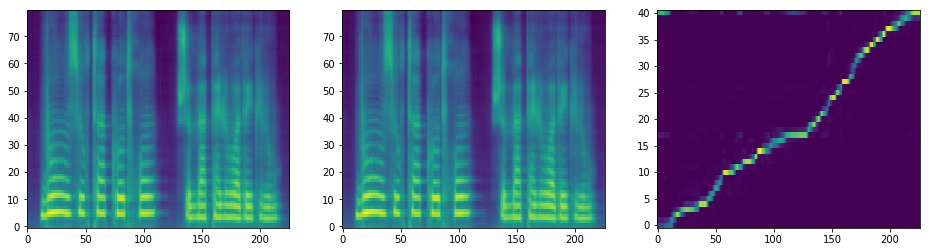

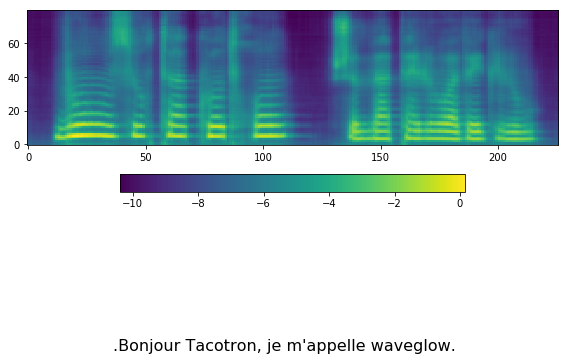

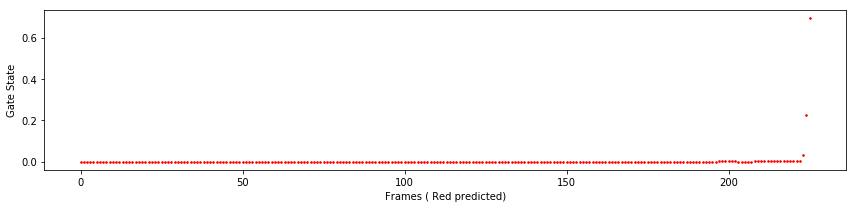

In [25]:
mel_outputs, mel_outputs_postnet, gate_outputs, alignments = model.inference(sequence,hparams)

plot_data((mel_outputs.float().data.cpu().numpy()[0],
        mel_outputs_postnet.float().data.cpu().numpy()[0],
        alignments.float().data.cpu().numpy()[0].T))

plot_spectrogram(mel_outputs.float().data.cpu().numpy()[0],title='{}'.format(text), split_title=True) 

print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

    
idx = random.randint(0, alignments.size(0) - 1)

plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'



In [17]:
#save mel spectrogram plot
_dir='/home/lebbatb-admin/Images'
plot_spectrogram(mel_outputs.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='{}'.format(text), split_title=True)  
#save mel_outputs_postnet plot
plot_spectrogram(mel_outputs_postnet.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/mel-post-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='mel postnet \r \n {}'.format(text), split_title=True)  
#print(mel_outputs_postnet.detach().cpu().numpy().shape[2])

#save alignments
plot_alignment(alignments.float().data.cpu().numpy()[0].T, os.path.join(_dir, 'plots/alignment-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='{}'.format(text), split_title=True)
#save gates 
idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
    torch.sigmoid(gate_outputs[idx]).data.cpu().numpy(), os.path.join(_dir, 'plots/gate-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='{}'.format(text), split_title=True)
# generate audio
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.6)
    audio_denoised = denoiser(audio, strength=0.05)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
#generate plot audio
plot_wave(audio_denoised.float().data.cpu().numpy()[0], os.path.join(_dir, 'plots/audio-{}.png'.format(split_title_line(text[-50:-1], max_words=1))),
    title='audio_denoised \r \n {}'.format(text), split_title=True)
#save audio
save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-waveglow-ljs-{}-.wav'.format(split_title_line(text[-50:-1], max_words=1))), sr=22050)

In [19]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin, hparams.mel_fmax)
stft_fn = STFT(hparams.filter_length, hparams.hop_length, hparams.win_length)

In [26]:
#audio = inv(mel_outputs_postnet.float().T.data.cpu().numpy()[:,:,0])
inverse_transform = stft.mel_inv_spectrogram(mel_outputs_postnet.float().data.cpu())
audio =griffin_lim(inverse_transform,stft_fn)

ipd.Audio(audio.data.cpu().numpy(), rate=22050)
#save_wav(audio[0].data.cpu().numpy(), os.path.join(_dir, 'wavs/wav-griffin-{}-.wav'.format(split_title_line(text[-50:-1], max_words=1))), sr=hparams.sampling_rate)


In [30]:
# hparams.fmax=8000
# hparams.sample_rate = 16000
# hparams.n_fft = 1024
# hparams.num_mels = 80
# hparams.fmin = 0
# hparams.power = 1.5
# hparams.win_size = hparams.win_length
# hparams.hop_size = hparams.hop_length
# hparams.griffin_lim_iters = 60 

# # print(mel_outputs_postnet.float().data.cpu().numpy()[0].shape)
# # FB = _build_mel_basis(hparams)
# # IFB= np.linalg.pinv(_build_mel_basis(hparams))
# # print(IFB.shape)
# # X = [] 
# # values = [float(s) for s in line.split()]
# #       X.append(values[0])

# # for i in range(79):
# #     plt.plot( IFB[:,i],'b')


# print(mel_outputs_postnet.float().T.data.cpu().numpy()[:,:,0].shape)

# #print(mel_outputs_postnet.float().data.cpu().numpy()[0].shape)
# audio = inv_mel_spectrogram_tensorflow(mel_outputs_postnet.float().T.data.cpu().numpy()[:,:,0], hparams)
# print(audio[:,0])
# #plt.plot(audio[])
# #ipd.Audio(audio.T.T.data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
mel_outputs2, mel_outputs_postnet2, _, alignments2 = model.inference(sequence2,hparams)
plot_data((mel_outputs2.float().data.cpu().numpy()[0],
        mel_outputs_postnet2.float().data.cpu().numpy()[0],
        alignments2.float().data.cpu().numpy()[0].T))
idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'



In [ ]:
mel_outputs3, mel_outputs_postnet3, _, alignments3 = model.inference(sequence3,hparams)
plot_data((mel_outputs3.float().data.cpu().numpy()[0],
        mel_outputs_postnet3.float().data.cpu().numpy()[0],
        alignments3.float().data.cpu().numpy()[0].T))

idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'



In [ ]:
mel_outputs4, mel_outputs_postnet4, _, alignments4 = model.inference(sequence4,hparams)
plot_data((mel_outputs4.float().data.cpu().numpy()[0],
        mel_outputs_postnet4.float().data.cpu().numpy()[0],
        alignments4.float().data.cpu().numpy()[0].T))
idx = random.randint(0, alignments.size(0) - 1)
plot_gate_outputs_to_numpy(
                torch.sigmoid(gate_outputs[idx]).data.cpu().numpy()) # ,dataformats='HWC'

# %% [markdown]
# #### Synthesize audio from spectrogram using WaveGlow


In [30]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    #print(audio.shape)
ipd.Audio(audio[0].data.cpu().numpy(), rate=22050)

# plt.figure()
# plt.plot(audio[0,:].cpu().numpy())



In [ ]:
with torch.no_grad():
    audio2 = waveglow.infer(mel_outputs_postnet2, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



In [ ]:
with torch.no_grad():
    audio3 = waveglow.infer(mel_outputs_postnet3, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



In [ ]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet4, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

# %% [markdown]
# #### (Optional) Remove WaveGlow bias


In [31]:
audio_denoised = denoiser(audio, strength=0.05)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=22050)
#save_wav(audio_denoised[0].data.cpu().numpy(), os.path.join('/home/lebbatb-admin/', '+{}jouer.wav'.format('.')), sr=hparams.sampling_rate)



In [ ]:
audio_denoised = denoiser(audio2, strength=0.02)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 



In [ ]:
audio_denoised = denoiser(audio3, strength=0.02)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

